In [1]:
import FinanceDataReader as fdr
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.3f}'.format

### **종목 선정 모델 개발**

이번절에서는 책에서 종목선정을 위해 사용할 GAM 모델을 개발하겠습니다. 아나콘다 프롬프트에서 conda install -c conda-forge pygam 로 설치를 해 줍니다. 관련 링크 https://anaconda.org/conda-forge/pygam

모델링을 위해 준비한 데이터를 읽습니다. 그리고 모델의 오버피팅을 최소화하기 위하여 타겟변수를 0 과 1 로 치환합니다. 5% 익절은 다음과 같이 데이터로 표현할 수 있습니다. - 'max_close' 가 5% 이상일 때 1, 아니면 0. 타겟 변수 - 'max_close' 를 만들고 값이 1 인 비율을 보니, 약 24% 입니다. 타겟변수의 비율이 너무 적으면 모델 트레이닝이 어렵습니다. 모델 트레이닝 용도로 5,000 개 샘플을 뽑아 예측모델을 만들고, 나머지 데이터는 테스트(혹은 백테스팅)를 하겠습니다. 

In [12]:
feature_all = pd.read_pickle('feature_all.pkl') 
feature_all['target'] = np.where(feature_all['max_close']>= 1.05, 1, 0)
target = feature_all['target'].mean()
print(f'% of target:{target: 5.1%}')

% of target: 24.2%


In [3]:
mdl_all = feature_all.drop(columns=['max_close', 'sector']).set_index([feature_all.index,'code'])

train = mdl_all.sample(10000, random_state=124)
test = mdl_all.loc[~mdl_all.index.isin(train.index)]

In [4]:
 train.drop(columns='target').info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10000 entries, (Timestamp('2021-10-28 00:00:00'), '036800') to (Timestamp('2021-11-05 00:00:00'), '298540')
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   price_z             10000 non-null  float64
 1   volume_z            10000 non-null  float64
 2   num_high/close      10000 non-null  float64
 3   num_long            10000 non-null  float64
 4   num_z>1.96          10000 non-null  float64
 5   num_win_market      10000 non-null  float64
 6   pct_win_market      10000 non-null  float64
 7   return over sector  10000 non-null  float64
dtypes: float64(8)
memory usage: 717.0+ KB


In [ ]:
# from pygam import LogisticGAM, s, f, te, l
# from sklearn.metrics import accuracy_score
# from sklearn.metrics import log_loss

# X = train.drop(columns='target')
# y = train['target']
# X_test = test.drop(columns='target')
# y_test = test['target']

# lambda_list = np.logspace(-3, 3, 7)

# accuracy_list = []
# logloss_list = []

# for lam in lambda_list:
#     gam = LogisticGAM(te(0,1, n_splines=5) + s(1) + s(2) + f(3) + l(4) + s(5) + s(6) + s(7), lam = lam).fit(X.to_numpy(), y.to_numpy())
    
#     pred = gam.predict(X_test)
#     prob = gam.predict_proba(X_test)
    
#     print(f'{lam}:{accuracy_score(y_test, pred):5.4f}, log loss:{log_loss(y_test, prob):5.4f}')
    
#     accuracy_list.append(accuracy_score(y_test, pred)) 
#     logloss_list.append(log_loss(y_test, prob)) 

# print(gam.summary())
# print(gam.accuracy(X_test, y_test))    

<br> 각 변수별로 다른 'lambda' (wiggliness Penalty Weight) 을 적용해서 grid Search 를 합니다. spline 수는 20 이 디폴트 값입니다. spline 수는 고정하고 lambda의 최적조합을 찾거나, lambda 를 고정하고 최적 spline 수 조합을 찾는 것이 현실적이고, 두 하이퍼파라미터를 동시에 조합하여 grid Search 하는 것은 시간이 많이 걸립니다.

In [11]:
from pygam import LogisticGAM, s, f, te, l
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

X = train.drop(columns='target')
y = train['target']
X_test = test.drop(columns='target')
y_test = test['target']

lambda_list = [np.logspace(-3, 3, 3)]*9
    
gam = LogisticGAM(te(0,1, n_splines=5) + s(1) + s(2) + f(3) + l(4) + s(5) + s(6) + s(7)).gridsearch(X.to_numpy(), y.to_numpy(), lam=lambda_list)
print(gam.summary())
print(gam.accuracy(X_test, y_test))

100% (19683 of 19683) |##################| Elapsed Time: 6:50:30 Time:  6:50:30


LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     27.0681
Link Function:                        LogitLink Log Likelihood:                                 -5386.1041
Number of Samples:                        10000 AIC:                                            10826.3444
                                                AICc:                                            10826.508
                                                UBRE:                                               3.0848
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.0245
Feature Function                  Lam

In [19]:
# import pickle
# with open("gam.pkl", "wb") as file:
#     pickle.dump(gam, file)    

In [106]:
with open("gam.pkl", "rb") as file:
    gam = pickle.load(file) 

In [107]:
gam.get_params()

{'max_iter': 100,
 'tol': 0.0001,
 'callbacks': [Deviance(), Diffs(), Accuracy()],
 'verbose': False,
 'terms': te(0, 1) + s(1) + s(2) + f(3) + l(4) + s(5) + s(6) + s(7) + intercept,
 'fit_intercept': True}

In [59]:
gam.coef_.shape

(130,)

<br> Partial Dependency 그래프를 그려서 예상했던 패턴인지 확인해봅니다. 

<Figure size 432x288 with 0 Axes>

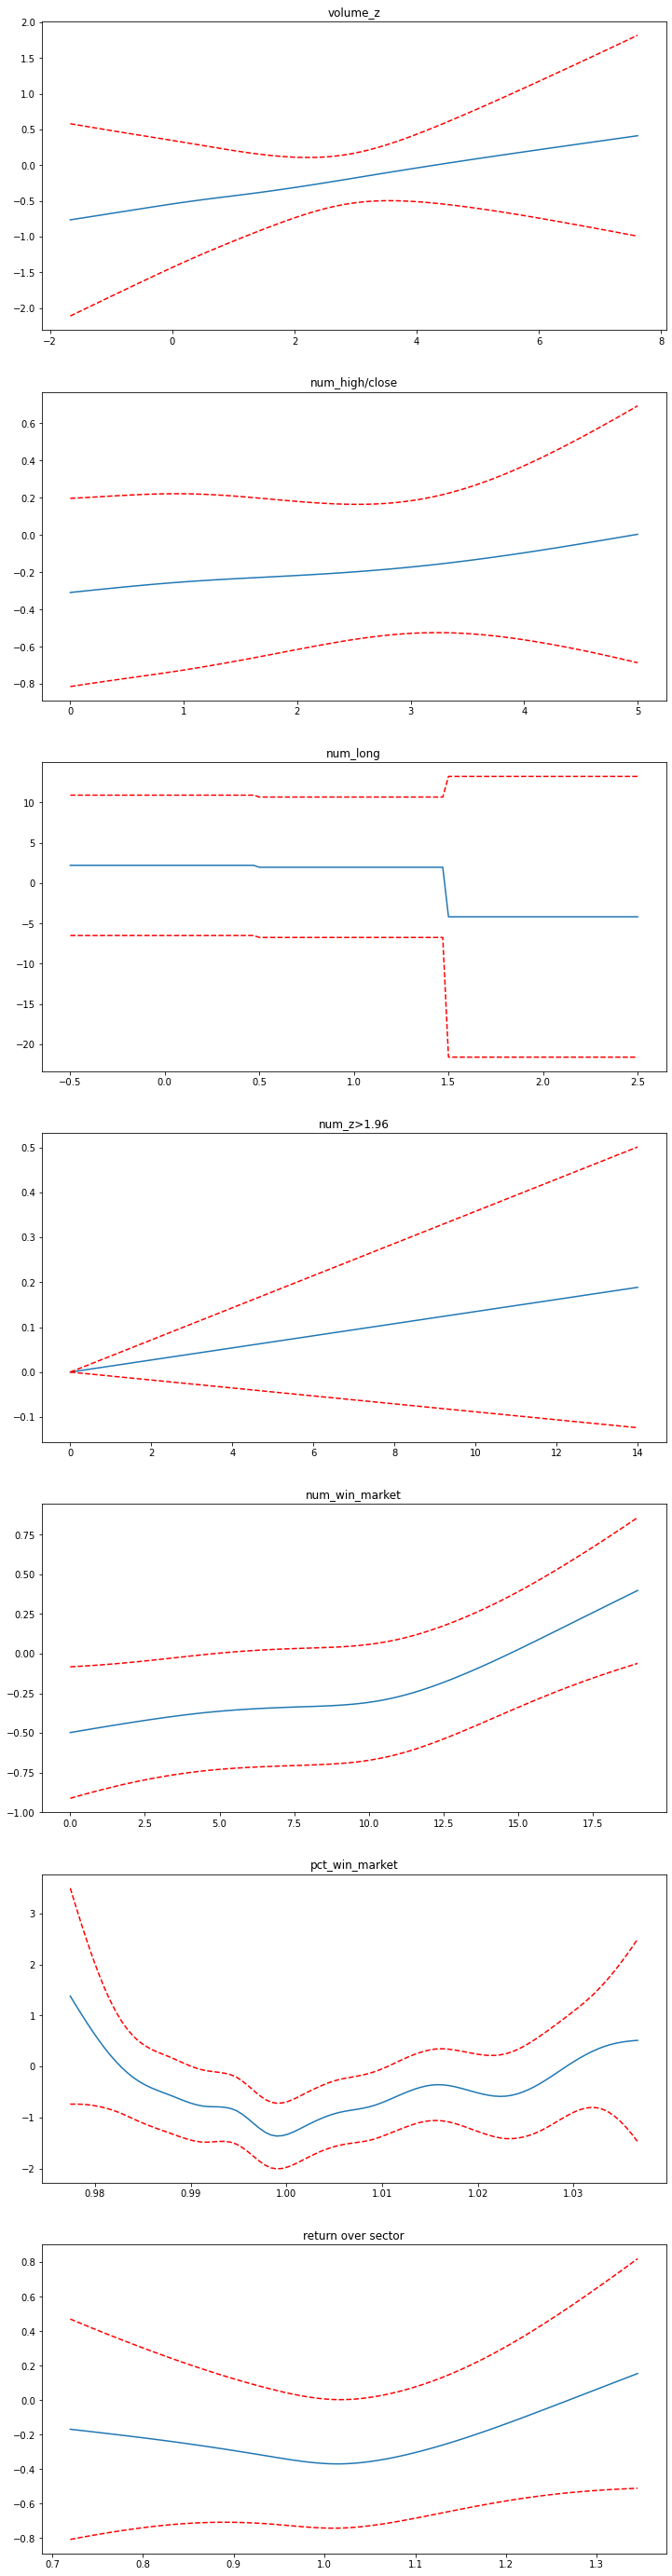

In [21]:
titles = list(train.columns)
plt.figure()
fig, axs = plt.subplots(7, 1, figsize=(12, 50))
for i, ax in enumerate(axs):
    i = i + 1
    XX = gam.generate_X_grid(term=i)

    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,  width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i])

In [17]:
yhat = gam.predict_proba(X.to_numpy())
yhat = pd.Series(yhat, name='yhat', index=y.index)

yhat_test = gam.predict_proba(X_test.to_numpy())
yhat_test = pd.Series(yhat_test, name='yhat', index=y_test.index)

                                  count  mean
yhat                                         
(-0.00032300000000000004, 0.171]   1000 0.172
(0.171, 0.189]                     1000 0.180
(0.189, 0.202]                     1000 0.167
(0.202, 0.215]                     1000 0.186
(0.215, 0.229]                     1000 0.223
(0.229, 0.244]                     1000 0.255
(0.244, 0.261]                     1000 0.249
(0.261, 0.285]                     1000 0.254
(0.285, 0.324]                     1000 0.316
(0.324, 0.782]                     1000 0.407
                                  count  mean
yhat                                         
(-0.00035000000000000005, 0.171]  29255 0.160
(0.171, 0.189]                    29254 0.182
(0.189, 0.202]                    29254 0.189
(0.202, 0.215]                    29255 0.203
(0.215, 0.229]                    29254 0.221
(0.229, 0.243]                    29254 0.235
(0.243, 0.261]                    29255 0.258
(0.261, 0.285]                    

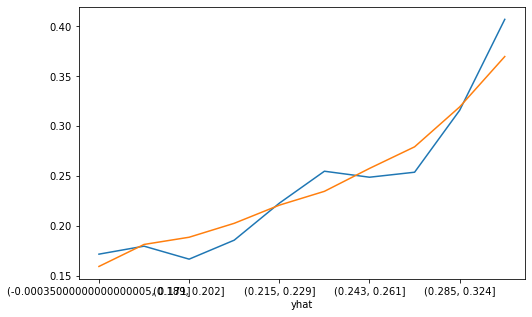

In [22]:
def perf(y, yhat): # Decile 분석 함수
    combined = pd.concat([y, yhat], axis=1)
    ranks = pd.qcut(combined['yhat'], q=10)
    print(combined.groupby(ranks)['target'].agg(['count','mean']))
    combined.groupby(ranks)['target'].mean().plot(figsize=(8,5))

perf(y, yhat)
perf(y_test, yhat_test)